<a href="https://colab.research.google.com/github/gyasifred/msc-thesis/blob/main/twi_french_seq_seq_nmt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Machine Translation**

This exercise will demonstrate how to build sequence to sequence models with attention for Twi-French machine translation. This code is based on the tensorflow implementation.The code snippet are adapted from from [[1]](https://www.tensorflow.org/text/tutorials/nmt_with_attention).

## Install Tensorflow 

In [1]:
!pip install "tensorflow-text==2.8.*"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Import libraries

In [2]:
import numpy as np
import unicodedata
import re
import os
import time
import collections
import logging
import os
import pathlib
import re
import string
import typing
from typing import Any, Tuple
import sys
import tempfile
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import tensorflow as tf
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

## The Data

The dataset for this exercise is taken from the paper ENGLISH-AKUAPEM TWI PARALLEL CORPUS and is available at [[2]](https://zenodo.org/record/4432117#.YxTaVtLP1Nj). The french translations were generated using  the googletrans python package [[3]](https://pypi.org/project/googletrans/)

Perform stanadardization, unicode normalisation and add aend and start tokens to each sentence

In [3]:
def read_dataset(number):

    french_data = []
    with open('/content/verified.french.txt') as file:

        line = file.readline()
        cnt = 1
        while line:
            french_data.append(line.strip())
            line = file.readline()
            cnt += 1

    twi_data = []
    with open('/content/verified.twi.txt') as file:

        line = file.readline()
        cnt = 1
        while line:
            twi_data.append(line.strip())
            line = file.readline()
            cnt += 1

    return french_data[:number],twi_data[:number]


def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')


def normalize_fr(s):
    s = unicode_to_ascii(s)
    s = re.sub(r'([!.?])', r' \1', s)
    s = re.sub(r'[^a-zA-Z.!?]+', r' ', s)
    s = re.sub(r'\s+', r' ', s)
    return s

def normalize_twi(s):
    s = unicode_to_ascii(s)
    s = re.sub(r'([!.?])', r' \1', s)
    s = re.sub(r'[^a-zA-Z.ƆɔɛƐ!?’]+', r' ', s)
    s = re.sub(r'\s+', r' ', s)
    return s

def add_start_end_token(text):
  # lower text
  text = tf.strings.lower(text)
  # Strip whitespace.
  text = tf.strings.strip(text)

  text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
  return text


raw_data_fr,raw_data_twi = read_dataset(10000)
raw_data_fr = [normalize_fr(data) for data in raw_data_fr]
raw_data_twi = [normalize_twi(data) for data in raw_data_twi]

with open('training_twi.txt', 'w') as f:
    for line in raw_data_twi:
        f.write(f"{line}\n")

with open('training_fr.txt', 'w') as f:
    for line in raw_data_fr:
        f.write(f"{line}\n")

In [4]:
# build TF datasets from input sentences in both languages
lines_dataset_fr = tf.data.TextLineDataset('/content/training_fr.txt')
lines_dataset_tw = tf.data.TextLineDataset('/content/training_twi.txt')

In [5]:
NUM_PAIRS = 0
for fr in lines_dataset_fr:
  NUM_PAIRS += 1
print('There are ' + str(NUM_PAIRS) + ' samples in training data')

There are 10000 samples in training data


In [6]:
# verify Twi file interpreted correctly
for twi in lines_dataset_tw.take(20):
  print("Twi: ", twi.numpy().decode('utf-8'))

Twi:  Nea onni ho adwempa no de adwumaden na ɛba .
Twi:  Na biribiara nni hɛ a metumi ayɔ
Twi:  Kwaku hui se John ne Abena kurakura wɛn nsa .
Twi:  So wubetumi atena ha akosi nnɛnmienu npaamu aduasa awiaberɔ .
Twi:  Wonni mmre
Twi:  Na ɛtotɛ nkosua aduonu abien .
Twi:  Minni nkrante .
Twi:  Dɔ n nti na abofra no suɔ
Twi:  Me na mewɔ ha .
Twi:  Na wonte ase .
Twi:  Kwaku to dwom yiye .
Twi:  Anadwo biara ɛfrɛ no .
Twi:  Kwaku fii ayaresabea hɔ kɔe .
Twi:  So mu denneennen
Twi:  Wubetumi adi nkonim wɔ ɔko no nyinaa mu nanso wubetumi ahwere ɔko no .
Twi:  Kwaku bɔɔ mmɔden sɛ obegyae ɔko a ɛkɔɔ so wɔ Abena ne John ntam no .
Twi:  M adwene ne sɛ mɛte eyi ase akɔ Franse kasa mu .
Twi:  Na megyae .
Twi:  Obiara ani gyee n akokoduru no ho .
Twi:  Na nsɔmmisa no ɔyɔ den .


In [7]:
# verify Hebrew file interpreted correctly
for fr in lines_dataset_fr.take(20):
  print("French: ", fr.numpy().decode('utf-8'))

French:  Ce qui lui manque en charisme elle le compense par avec travail acharne .
French:  il n y avait rien je pourrais faire a ce sujet .
French:  Kwaku vit John et Abena se tenir la main .
French:  Pouvez vous rester jusqu a h ?
French:  Vous n avez pas beaucoup de temps .
French:  Elle a achete deux douzaines d ufs .
French:  Je n ai pas d epee .
French:  Pourquoi cette bebe pleure t il ?
French:  J appartiens ici .
French:  Vous n a pas pas compris .
French:  Kwaku chante plutot bien .
French:  Il l appelle tous les soirs .
French:  Kwaku est sorti de l hopital .
French:  Accrochez vous bien .
French:  Vous pouvez gagner toutes les batailles encore perdre la guerre .
French:  Kwaku a essaye de briser le combat entre Abena et John .
French:  Je pense le faire traduire en francais
French:  J arreterai .
French:  Tout le monde admirait son courage .
French:  c est une question difficile


In [8]:
# combine languages into single dataset
combined = tf.data.Dataset.zip((lines_dataset_tw, lines_dataset_fr))

In [9]:
# verify combined dataset is correct
for tw,fr in combined.take(20):
  print("Twi: ", tw.numpy().decode('utf-8'))
  print("French: ", fr.numpy().decode('utf-8'))
  

Twi:  Nea onni ho adwempa no de adwumaden na ɛba .
French:  Ce qui lui manque en charisme elle le compense par avec travail acharne .
Twi:  Na biribiara nni hɛ a metumi ayɔ
French:  il n y avait rien je pourrais faire a ce sujet .
Twi:  Kwaku hui se John ne Abena kurakura wɛn nsa .
French:  Kwaku vit John et Abena se tenir la main .
Twi:  So wubetumi atena ha akosi nnɛnmienu npaamu aduasa awiaberɔ .
French:  Pouvez vous rester jusqu a h ?
Twi:  Wonni mmre
French:  Vous n avez pas beaucoup de temps .
Twi:  Na ɛtotɛ nkosua aduonu abien .
French:  Elle a achete deux douzaines d ufs .
Twi:  Minni nkrante .
French:  Je n ai pas d epee .
Twi:  Dɔ n nti na abofra no suɔ
French:  Pourquoi cette bebe pleure t il ?
Twi:  Me na mewɔ ha .
French:  J appartiens ici .
Twi:  Na wonte ase .
French:  Vous n a pas pas compris .
Twi:  Kwaku to dwom yiye .
French:  Kwaku chante plutot bien .
Twi:  Anadwo biara ɛfrɛ no .
French:  Il l appelle tous les soirs .
Twi:  Kwaku fii ayaresabea hɔ kɔe .
French:  Kw

## Create a tf.data dataset

In [10]:
BUFFER_SIZE = NUM_PAIRS 
BATCH_SIZE = 64
def make_batches(ds):
  return (
  ds
  .cache()
  .shuffle(BUFFER_SIZE)
  .batch(BATCH_SIZE))

In [11]:
dataset = make_batches(combined)
dataset

<BatchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None))>

In [16]:
for  example_input_batch,example_target_batch in dataset.take(1):
  print(example_input_batch[:5])
  print()
  print(example_target_batch[:5])
  break

tf.Tensor(
[b'Bere a Asamoah yii mfonini a w\xc9\x94atwa no mfonini no fii h\xc9\x94 no \xc9\x94hw\xc9\x9b\xc9\x9b mu yiye .'
 b'Minnim \xc9\x9bho ns\xc9\x9bm nyinaa .'
 b'\xc6\x90s\xc9\x9b s\xc9\x9b woka kyer\xc9\x9b Asamoah s\xc9\x9b Aku ny\xc9\x9b n adwene s\xc9\x9b \xc9\x94b\xc9\x9bk\xc9\x94 .'
 b'Asamoah de atuo maa Boatemaa' b'Wo nhoma no adane .'], shape=(5,), dtype=string)

tf.Tensor(
[b'Asamoah a enleve la photo encadree de la cheminee et l a regardee de plus pres .'
 b'Je ne connais pas les details .'
 b'Tu devrais dire a Asamoah qu Aku n a pas l intention d y aller .'
 b'Asamoah tendit une arme a Boatemaa .' b'Votre livre est a l envers .'], shape=(5,), dtype=string)


In [17]:
# add start and end tokens
def tf_start_and_end_tokens(text):
  # Split accented characters.
  #text = tf_text.normalize_utf8(text, 'NFKD')
  text = tf.strings.lower(text)
  # Strip whitespace.
  text = tf.strings.strip(text)

  text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
  return text

In [18]:
# verify if start and end tokens
example_text = tf.constant('Ɛhe na saa frankaa yi fi ba ?')
print(example_text.numpy().decode())
print(tf_start_and_end_tokens(example_text).numpy().decode())

Ɛhe na saa frankaa yi fi ba ?
[START] Ɛhe na saa frankaa yi fi ba ? [END]


## Text Vectorization

This standardization function will be wrapped up in a tf.keras.layers.TextVectorization layer which will handle the vocabulary extraction and conversion of input text to sequences of tokens.

In [19]:
max_vocab_size = 5000


In [20]:
# Process twi as input
input_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_start_and_end_tokens,
    max_tokens=max_vocab_size)
input_text_processor.adapt(lines_dataset_tw)
# Here are the first 10 words from the vocabulary:
input_text_processor.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', '.', 'no', 'sɛ', 'a', 'na', 'so']

In [21]:
# Process french as output
output_text_processor = tf.keras.layers.TextVectorization(
    standardize=tf_start_and_end_tokens,
    max_tokens=max_vocab_size)

output_text_processor.adapt(lines_dataset_fr)
output_text_processor.get_vocabulary()[:10]

['', '[UNK]', '[START]', '[END]', '.', 'a', 'de', 'je', 'est', 'asamoah']

Now these layers can convert a batch of strings into a batch of token IDs:

In [22]:
example_tokens = input_text_processor(example_input_batch)
example_tokens[:3, :10]

<tf.Tensor: shape=(3, 10), dtype=int64, numpy=
array([[   2,   19,    7,   10,  804,  172,    7, 1757,    5,  172],
       [   2,  132,  303,  135,   38,    4,    3,    0,    0,    0],
       [   2,   64,    6,  270,   86,   10,    6,  130,   70,   29]])>

The get_vocabulary method can be used to convert token IDs back to text:



In [23]:
input_vocab = np.array(input_text_processor.get_vocabulary())
tokens = input_vocab[example_tokens[0].numpy()]
' '.join(tokens)

'[START] bere a asamoah yii mfonini a wɔatwa no mfonini no fii hɔ no ɔhwɛɛ mu yiye . [END]'

The returned token IDs are zero-padded. This can easily be turned into a mask:

Text(0.5, 1.0, 'Mask')

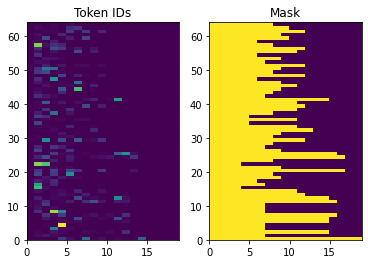

In [24]:
plt.subplot(1, 2, 1)
plt.pcolormesh(example_tokens)
plt.title('Token IDs')

plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens != 0)
plt.title('Mask')

In [25]:
embedding_dim = 256
units = 1024

## The Encoder

In [26]:
# Creating the Encoder RNN
class Encoder(tf.keras.layers.Layer):
  def __init__(self, input_vocab_size, embedding_dim, enc_units):
    super(Encoder, self).__init__()
    self.enc_units = enc_units
    self.input_vocab_size = input_vocab_size

    # The embedding layer converts tokens to vectors
    self.embedding = tf.keras.layers.Embedding(self.input_vocab_size,
                                               embedding_dim)

    # The GRU RNN layer processes those vectors sequentially.
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   # Return the sequence and state
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

  def call(self, tokens, state=None):
    # shape_checker = ShapeChecker()
    # shape_checker(tokens, ('batch', 's'))

    # 2. The embedding layer looks up the embedding for each token.
    vectors = self.embedding(tokens)
    #shape_checker(vectors, ('batch', 's', 'embed_dim'))

    # 3. The GRU processes the embedding sequence.
    #    output shape: (batch, s, enc_units)
    #    state shape: (batch, enc_units)
    output, state = self.gru(vectors, initial_state=state)
    # shape_checker(output, ('batch', 's', 'enc_units'))
    # shape_checker(state, ('batch', 'enc_units'))

    # 4. Returns the new sequence and its state.
    return output, state

In [27]:
# Convert the input text to tokens.
example_tokens = input_text_processor(example_input_batch)

# Encode the input sequence.
encoder = Encoder(input_text_processor.vocabulary_size(),
                  embedding_dim, units)
example_enc_output, example_enc_state = encoder(example_tokens)

print(f'Input batch, shape (batch): {example_input_batch.shape}')
print(f'Input batch tokens, shape (batch, s): {example_tokens.shape}')
print(f'Encoder output, shape (batch, s, units): {example_enc_output.shape}')
print(f'Encoder state, shape (batch, units): {example_enc_state.shape}')

Input batch, shape (batch): (64,)
Input batch tokens, shape (batch, s): (64, 19)
Encoder output, shape (batch, s, units): (64, 19, 1024)
Encoder state, shape (batch, units): (64, 1024)


## The attention head

This tutorial uses Bahdanau's additive attention [[3]](https://arxiv.org/pdf/1409.0473.pdf)

In [28]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super().__init__()
    # For Eqn. (4), the  Bahdanau attention
    self.W1 = tf.keras.layers.Dense(units, use_bias=False)
    self.W2 = tf.keras.layers.Dense(units, use_bias=False)

    self.attention = tf.keras.layers.AdditiveAttention()

  def call(self, query, value, mask):
    # shape_checker = ShapeChecker()
    # shape_checker(query, ('batch', 't', 'query_units'))
    # shape_checker(value, ('batch', 's', 'value_units'))
    # shape_checker(mask, ('batch', 's'))

    # From Eqn. (4), `W1@ht`.
    w1_query = self.W1(query)
    #shape_checker(w1_query, ('batch', 't', 'attn_units'))

    # From Eqn. (4), `W2@hs`.
    w2_key = self.W2(value)
    #shape_checker(w2_key, ('batch', 's', 'attn_units'))

    query_mask = tf.ones(tf.shape(query)[:-1], dtype=bool)
    value_mask = mask

    context_vector, attention_weights = self.attention(
        inputs = [w1_query, value, w2_key],
        mask=[query_mask, value_mask],
        return_attention_scores = True,
    )
    # shape_checker(context_vector, ('batch', 't', 'value_units'))
    # shape_checker(attention_weights, ('batch', 't', 's'))

    return context_vector, attention_weights

In [29]:
attention_layer = BahdanauAttention(units)

In [30]:
(example_tokens != 0).shape

TensorShape([64, 19])

In [31]:
# Later, the decoder will generate this attention query
example_attention_query = tf.random.normal(shape=[len(example_tokens), 2, 10])

# Attend to the encoded tokens
context_vector, attention_weights = attention_layer(
    query=example_attention_query,
    value=example_enc_output,
    mask=(example_tokens != 0))

print(f'Attention result shape: (batch_size, query_seq_length, units):           {context_vector.shape}')
print(f'Attention weights shape: (batch_size, query_seq_length, value_seq_length): {attention_weights.shape}')

Attention result shape: (batch_size, query_seq_length, units):           (64, 2, 1024)
Attention weights shape: (batch_size, query_seq_length, value_seq_length): (64, 2, 19)


The attention weights should sum to 1.0 for each sequence.

Here are the attention weights across the sequences at t=0:

Text(0.5, 1.0, 'Mask')

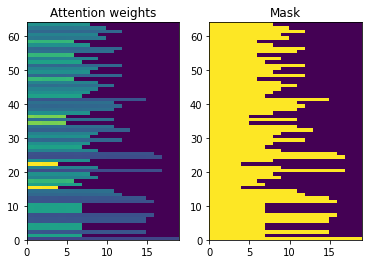

In [32]:
plt.subplot(1, 2, 1)
plt.pcolormesh(attention_weights[:, 0, :])
plt.title('Attention weights')

plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens != 0)
plt.title('Mask')

In [33]:
attention_slice = attention_weights[0, 0].numpy()
attention_slice = attention_slice[attention_slice != 0]

In [34]:
attention_weights.shape

TensorShape([64, 2, 19])

<Figure size 432x288 with 0 Axes>

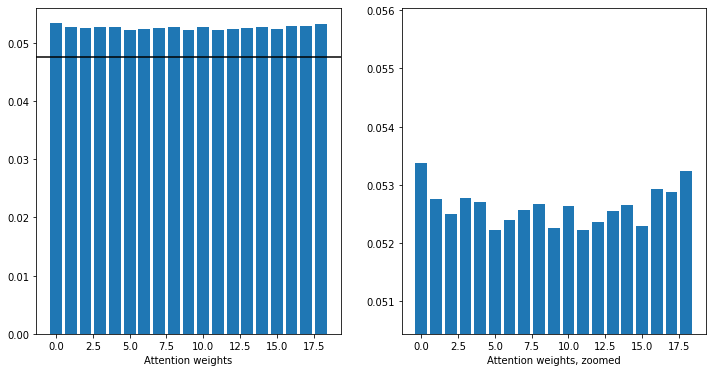

In [35]:
plt.suptitle('Attention weights for one sequence')

plt.figure(figsize=(12, 6))
a1 = plt.subplot(1, 2, 1)
plt.bar(range(len(attention_slice)), attention_slice)
# freeze the xlim
plt.xlim(plt.xlim())
plt.xlabel('Attention weights')

a2 = plt.subplot(1, 2, 2)
plt.bar(range(len(attention_slice)), attention_slice)
plt.xlabel('Attention weights, zoomed')

# zoom in
top = max(a1.get_ylim())
zoom = 0.85*top
a2.set_ylim([0.90*top, top])
a1.plot(a1.get_xlim(), [zoom, zoom], color='k')

## The Decoder

In [36]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, output_vocab_size, embedding_dim, dec_units):
    super(Decoder, self).__init__()
    self.dec_units = dec_units
    self.output_vocab_size = output_vocab_size
    self.embedding_dim = embedding_dim

    # For Step 1. The embedding layer converts token IDs to vectors
    self.embedding = tf.keras.layers.Embedding(self.output_vocab_size,
                                               embedding_dim)

    # For Step 2. The RNN keeps track of what's been generated so far.
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')

    # For step 3. The RNN output will be the query for the attention layer.
    self.attention = BahdanauAttention(self.dec_units)

    # For step 4. Eqn. (3): converting `ct` to `at`
    self.Wc = tf.keras.layers.Dense(dec_units, activation=tf.math.tanh,
                                    use_bias=False)

    # For step 5. This fully connected layer produces the logits for each
    # output token.
    self.fc = tf.keras.layers.Dense(self.output_vocab_size)

In [37]:
class DecoderInput(typing.NamedTuple):
  new_tokens: Any
  enc_output: Any
  mask: Any

class DecoderOutput(typing.NamedTuple):
  logits: Any
  attention_weights: Any

In [38]:
def call(self,
         inputs: DecoderInput,
         state=None) -> Tuple[DecoderOutput, tf.Tensor]:
  # shape_checker = ShapeChecker()
  # shape_checker(inputs.new_tokens, ('batch', 't'))
  # shape_checker(inputs.enc_output, ('batch', 's', 'enc_units'))
  # shape_checker(inputs.mask, ('batch', 's'))

  # if state is not None:
  #   shape_checker(state, ('batch', 'dec_units'))

  # Step 1. Lookup the embeddings
  vectors = self.embedding(inputs.new_tokens)
  #shape_checker(vectors, ('batch', 't', 'embedding_dim'))

  # Step 2. Process one step with the RNN
  rnn_output, state = self.gru(vectors, initial_state=state)

  # shape_checker(rnn_output, ('batch', 't', 'dec_units'))
  # shape_checker(state, ('batch', 'dec_units'))

  # Step 3. Use the RNN output as the query for the attention over the
  # encoder output.
  context_vector, attention_weights = self.attention(
      query=rnn_output, value=inputs.enc_output, mask=inputs.mask)
  # shape_checker(context_vector, ('batch', 't', 'dec_units'))
  # shape_checker(attention_weights, ('batch', 't', 's'))

  # Step 4. Eqn. (3): Join the context_vector and rnn_output
  #     [ct; ht] shape: (batch t, value_units + query_units)
  context_and_rnn_output = tf.concat([context_vector, rnn_output], axis=-1)

  # Step 4. Eqn. (3): `at = tanh(Wc@[ct; ht])`
  attention_vector = self.Wc(context_and_rnn_output)
  #shape_checker(attention_vector, ('batch', 't', 'dec_units'))

  # Step 5. Generate logit predictions:
  logits = self.fc(attention_vector)
  #shape_checker(logits, ('batch', 't', 'output_vocab_size'))

  return DecoderOutput(logits, attention_weights), state

In [39]:
Decoder.call = call

In [40]:
# VERIFY DECODER
decoder = Decoder(output_text_processor.vocabulary_size(),
                  embedding_dim, units)

In [41]:
# Convert the target sequence, and collect the "[START]" tokens
example_output_tokens = output_text_processor(example_target_batch)

start_index = output_text_processor.get_vocabulary().index('[START]')
first_token = tf.constant([[start_index]] * example_output_tokens.shape[0])

In [42]:
# Run the decoder
dec_result, dec_state = decoder(
    inputs = DecoderInput(new_tokens=first_token,
                          enc_output=example_enc_output,
                          mask=(example_tokens != 0)),
    state = example_enc_state
)

print(f'logits shape: (batch_size, t, output_vocab_size) {dec_result.logits.shape}')
print(f'state shape: (batch_size, dec_units) {dec_state.shape}')

logits shape: (batch_size, t, output_vocab_size) (64, 1, 5000)
state shape: (batch_size, dec_units) (64, 1024)


In [43]:
# Sample a token according to the logits:
sampled_token = tf.random.categorical(dec_result.logits[:, 0, :], num_samples=1)

In [44]:
#Decode the token as the first word of the output:
vocab = np.array(output_text_processor.get_vocabulary())
first_word = vocab[sampled_token.numpy()]
first_word[:5]

array([['echec'],
       ['autour'],
       ['detestent'],
       ['italie'],
       ['metal']], dtype='<U18')

Now use the decoder to generate a second set of logits.


1.   Pass the same enc_output and mask, these haven't changed.
2.   Pass the sampled token as new_tokens
3.   Pass the decoder_state the decoder returned last time, so the RNN continues with a memory of where it left off last time





In [45]:
dec_result, dec_state = decoder(
    DecoderInput(sampled_token,
                 example_enc_output,
                 mask=(example_tokens != 0)),
    state=dec_state)

In [46]:
sampled_token = tf.random.categorical(dec_result.logits[:, 0, :], num_samples=1)
first_word = vocab[sampled_token.numpy()]
first_word[:5]

array([['parait'],
       ['chemise'],
       ['repandit'],
       ['chanteuse'],
       ['couru']], dtype='<U18')

## Training

In [47]:
class MaskedLoss(tf.keras.losses.Loss):
  def __init__(self):
    self.name = 'masked_loss'
    self.loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')

  def __call__(self, y_true, y_pred):
    # shape_checker = ShapeChecker()
    # shape_checker(y_true, ('batch', 't'))
    # shape_checker(y_pred, ('batch', 't', 'logits'))

    # Calculate the loss for each item in the batch.
    loss = self.loss(y_true, y_pred)
    #shape_checker(loss, ('batch', 't'))

    # Mask off the losses on padding.
    mask = tf.cast(y_true != 0, tf.float32)
    #shape_checker(mask, ('batch', 't'))
    loss *= mask

    # Return the total.
    return tf.reduce_sum(loss)

In [48]:
class TrainTranslator(tf.keras.Model):
  def __init__(self, embedding_dim, units,
               input_text_processor,
               output_text_processor,
               use_tf_function=True):
    super().__init__()
    # Build the encoder and decoder
    encoder = Encoder(input_text_processor.vocabulary_size(),
                      embedding_dim, units)
    decoder = Decoder(output_text_processor.vocabulary_size(),
                      embedding_dim, units)

    self.encoder = encoder
    self.decoder = decoder
    self.input_text_processor = input_text_processor
    self.output_text_processor = output_text_processor
    self.use_tf_function = use_tf_function
    #self.shape_checker = ShapeChecker()

  def train_step(self, inputs):
    #.shape_checker = ShapeChecker()
    if self.use_tf_function:
      return self._tf_train_step(inputs)
    else:
      return self._train_step(inputs)

In [49]:
# Implement preprocessing step to:
# Receive a batch of input_text, target_text from the tf.data.Dataset.
# Convert those raw text inputs to token-embeddings and masks.
def _preprocess(self, input_text, target_text):
  # self.shape_checker(input_text, ('batch',))
  # self.shape_checker(target_text, ('batch',))

  # Convert the text to token IDs
  input_tokens = self.input_text_processor(input_text)
  target_tokens = self.output_text_processor(target_text)
  # self.shape_checker(input_tokens, ('batch', 's'))
  # self.shape_checker(target_tokens, ('batch', 't'))

  # Convert IDs to masks.
  input_mask = input_tokens != 0
  #self.shape_checker(input_mask, ('batch', 's'))

  target_mask = target_tokens != 0
  #self.shape_checker(target_mask, ('batch', 't'))

  return input_tokens, input_mask, target_tokens, target_mask

In [50]:
TrainTranslator._preprocess = _preprocess

In [51]:
# the function The _train_step:
#Run the encoder on the input_tokens to get the encoder_output and encoder_state.
#Initialize the decoder state and loss.
#Loop over the target_tokens:
#   Run the decoder one step at a time.
#   Calculate the loss for each step.
#Accumulate the average loss.
#Calculate the gradient of the loss and use the optimizer to apply updates to the model's trainable_variables.
def _train_step(self, inputs):
  input_text, target_text = inputs

  (input_tokens, input_mask,
   target_tokens, target_mask) = self._preprocess(input_text, target_text)

  max_target_length = tf.shape(target_tokens)[1]

  with tf.GradientTape() as tape:
    # Encode the input
    enc_output, enc_state = self.encoder(input_tokens)
    # self.shape_checker(enc_output, ('batch', 's', 'enc_units'))
    # self.shape_checker(enc_state, ('batch', 'enc_units'))

    # Initialize the decoder's state to the encoder's final state.
    # This only works if the encoder and decoder have the same number of
    # units.
    dec_state = enc_state
    loss = tf.constant(0.0)

    for t in tf.range(max_target_length-1):
      # Pass in two tokens from the target sequence:
      # 1. The current input to the decoder.
      # 2. The target for the decoder's next prediction.
      new_tokens = target_tokens[:, t:t+2]
      step_loss, dec_state = self._loop_step(new_tokens, input_mask,
                                             enc_output, dec_state)
      loss = loss + step_loss

    # Average the loss over all non padding tokens.
    average_loss = loss / tf.reduce_sum(tf.cast(target_mask, tf.float32))

  # Apply an optimization step
  variables = self.trainable_variables
  gradients = tape.gradient(average_loss, variables)
  self.optimizer.apply_gradients(zip(gradients, variables))

  # Return a dict mapping metric names to current value
  return {'batch_loss': average_loss}

In [52]:
TrainTranslator._train_step = _train_step

In [53]:
#The _loop_step method, added below, executes the decoder and calculates the incremental loss and new decoder state (dec_state).
def _loop_step(self, new_tokens, input_mask, enc_output, dec_state):
  input_token, target_token = new_tokens[:, 0:1], new_tokens[:, 1:2]

  # Run the decoder one step.
  decoder_input = DecoderInput(new_tokens=input_token,
                               enc_output=enc_output,
                               mask=input_mask)

  dec_result, dec_state = self.decoder(decoder_input, state=dec_state)
  # self.shape_checker(dec_result.logits, ('batch', 't1', 'logits'))
  # self.shape_checker(dec_result.attention_weights, ('batch', 't1', 's'))
  # self.shape_checker(dec_state, ('batch', 'dec_units'))

  # `self.loss` returns the total for non-padded tokens
  y = target_token
  y_pred = dec_result.logits
  step_loss = self.loss(y, y_pred)

  return step_loss, dec_state

In [54]:
TrainTranslator._loop_step = _loop_step

In [55]:
translator = TrainTranslator(
    embedding_dim, units,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor,
    use_tf_function=False)
# Configure the loss and optimizer
translator.compile(
    optimizer=tf.optimizers.Adam(),
    loss=MaskedLoss(),
)

In [56]:
np.log(output_text_processor.vocabulary_size())

8.517193191416238

In [57]:
%%time
for n in range(10):
  print(translator.train_step([example_input_batch, example_target_batch]))
print()

{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.702392>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.674491>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.6219454>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=7.4706807>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=6.919408>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=5.0313168>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=5.4071965>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.5035076>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.2916613>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.2763476>}

CPU times: user 2min 9s, sys: 3.29 s, total: 2min 13s
Wall time: 1min 18s


While it's easier to debug without a tf.function it does give a performance boost. So now that the _train_step method is working, try the tf.function-wrapped _tf_train_step, to maximize performance while training:




In [58]:
@tf.function(input_signature=[[tf.TensorSpec(dtype=tf.string, shape=[None]),
                               tf.TensorSpec(dtype=tf.string, shape=[None])]])
def _tf_train_step(self, inputs):
  return self._train_step(inputs)

In [59]:
TrainTranslator._tf_train_step = _tf_train_step

In [60]:
translator.use_tf_function = True

In [61]:
translator.train_step([example_input_batch, example_target_batch])

{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.304758>}

In [ ]:
%%time
for n in range(10):
  print(translator.train_step([example_input_batch, example_target_batch]))
print()

{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.3337536>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.3174896>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.2627645>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.1902537>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.118381>}
{'batch_loss': <tf.Tensor: shape=(), dtype=float32, numpy=4.055052>}


A good test of a new model is to see that it can overfit a single batch of input. Try it, the loss should quickly go to zero:

In [ ]:
losses = []
for n in range(100):
  print('.', end='')
  logs = translator.train_step([example_input_batch, example_target_batch])
  losses.append(logs['batch_loss'].numpy())

print()
plt.plot(losses)

In [ ]:
# build new copy of translator to train
train_translator = TrainTranslator(
    embedding_dim, units,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor)

# Configure the loss and optimizer
train_translator.compile(
    optimizer=tf.optimizers.Adam(),
    loss=MaskedLoss(),
)

In [ ]:
class BatchLogs(tf.keras.callbacks.Callback):
  def __init__(self, key):
    self.key = key
    self.logs = []

  def on_train_batch_end(self, n, logs):
    self.logs.append(logs[self.key])

batch_loss = BatchLogs('batch_loss')

In [ ]:
train_translator.fit(dataset, epochs=100,
                     callbacks=[batch_loss])

In [ ]:
plt.plot(batch_loss.logs)
plt.ylim([0, 3])
plt.xlabel('Batch #')
plt.ylabel('CE/token')

In [ ]:
class Translator(tf.Module):

  def __init__(self, encoder, decoder, input_text_processor,
               output_text_processor):
    self.encoder = encoder
    self.decoder = decoder
    self.input_text_processor = input_text_processor
    self.output_text_processor = output_text_processor

    self.output_token_string_from_index = (
        tf.keras.layers.StringLookup(
            vocabulary=output_text_processor.get_vocabulary(),
            mask_token='',
            invert=True))

    # The output should never generate padding, unknown, or start.
    index_from_string = tf.keras.layers.StringLookup(
        vocabulary=output_text_processor.get_vocabulary(), mask_token='')
    token_mask_ids = index_from_string(['', '[UNK]', '[START]']).numpy()

    token_mask = np.zeros([index_from_string.vocabulary_size()], dtype=np.bool)
    token_mask[np.array(token_mask_ids)] = True
    self.token_mask = token_mask

    self.start_token = index_from_string(tf.constant('[START]'))
    self.end_token = index_from_string(tf.constant('[END]'))

In [ ]:
translator = Translator(
    encoder=train_translator.encoder,
    decoder=train_translator.decoder,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor,
)

## Convert token IDs to tex

In [ ]:
def tokens_to_text(self, result_tokens):
  # shape_checker = ShapeChecker()
  # shape_checker(result_tokens, ('batch', 't'))
  result_text_tokens = self.output_token_string_from_index(result_tokens)
  # shape_checker(result_text_tokens, ('batch', 't'))

  result_text = tf.strings.reduce_join(result_text_tokens,
                                       axis=1, separator=' ')
  #shape_checker(result_text, ('batch'))

  result_text = tf.strings.strip(result_text)
  #shape_checker(result_text, ('batch',))
  return result_text

In [ ]:
Translator.tokens_to_text = tokens_to_text

In [ ]:
#Input some random token IDs and see what it generates:
example_output_tokens = tf.random.uniform(
    shape=[5, 2], minval=0, dtype=tf.int64,
    maxval=output_text_processor.vocabulary_size())
translator.tokens_to_text(example_output_tokens).numpy()

Sample from the decoder's predictions

In [ ]:
def sample(self, logits, temperature):
  # shape_checker = ShapeChecker()
  # # 't' is usually 1 here.
  # shape_checker(logits, ('batch', 't', 'vocab'))
  # shape_checker(self.token_mask, ('vocab',))

  token_mask = self.token_mask[tf.newaxis, tf.newaxis, :]
  #shape_checker(token_mask, ('batch', 't', 'vocab'), broadcast=True)

  # Set the logits for all masked tokens to -inf, so they are never chosen.
  logits = tf.where(self.token_mask, -np.inf, logits)

  if temperature == 0.0:
    new_tokens = tf.argmax(logits, axis=-1)
  else:
    logits = tf.squeeze(logits, axis=1)
    new_tokens = tf.random.categorical(logits/temperature,
                                        num_samples=1)

  #shape_checker(new_tokens, ('batch', 't'))

  return new_tokens

In [ ]:
Translator.sample = sample

In [ ]:
# Test run this function on some random inputs:

example_logits = tf.random.normal([5, 1, output_text_processor.vocabulary_size()])
example_output_tokens = translator.sample(example_logits, temperature=1.0)
example_output_tokens

In [ ]:
# Implement the translation loop
def translate_unrolled(self,
                       input_text, *,
                       max_length=50,
                       return_attention=True,
                       temperature=1.0):
  batch_size = tf.shape(input_text)[0]
  input_tokens = self.input_text_processor(input_text)
  enc_output, enc_state = self.encoder(input_tokens)

  dec_state = enc_state
  new_tokens = tf.fill([batch_size, 1], self.start_token)

  result_tokens = []
  attention = []
  done = tf.zeros([batch_size, 1], dtype=tf.bool)

  for _ in range(max_length):
    dec_input = DecoderInput(new_tokens=new_tokens,
                             enc_output=enc_output,
                             mask=(input_tokens!=0))

    dec_result, dec_state = self.decoder(dec_input, state=dec_state)

    attention.append(dec_result.attention_weights)

    new_tokens = self.sample(dec_result.logits, temperature)

    # If a sequence produces an `end_token`, set it `done`
    done = done | (new_tokens == self.end_token)
    # Once a sequence is done it only produces 0-padding.
    new_tokens = tf.where(done, tf.constant(0, dtype=tf.int64), new_tokens)

    # Collect the generated tokens
    result_tokens.append(new_tokens)

    if tf.executing_eagerly() and tf.reduce_all(done):
      break

  # Convert the list of generates token ids to a list of strings.
  result_tokens = tf.concat(result_tokens, axis=-1)
  result_text = self.tokens_to_text(result_tokens)

  if return_attention:
    attention_stack = tf.concat(attention, axis=1)
    return {'text': result_text, 'attention': attention_stack}
  else:
    return {'text': result_text}

In [ ]:
Translator.translate = translate_unrolled

In [ ]:
# Run it on a simple input:
%%time
input_text = tf.constant([
    'Yɛn agyanom Nyankopɔn .', # "Dieu de nos pères."
    'Eyi ne m’asetra .', # "C'est ma vie.""
])

result = translator.translate(
    input_text = input_text)

print(result['text'][0].numpy().decode())
print(result['text'][1].numpy().decode())
print()

In [ ]:
@tf.function(input_signature=[tf.TensorSpec(dtype=tf.string, shape=[None])])
def tf_translate(self, input_text):
  return self.translate(input_text)

Translator.tf_translate = tf_translate

In [ ]:
%%time
result = translator.tf_translate(
    input_text = input_text)

In [ ]:
%%time
result = translator.tf_translate(
    input_text = input_text)

print(result['text'][0].numpy().decode())
print(result['text'][1].numpy().decode())
print()

In [ ]:
a = result['attention'][0]

print(np.sum(a, axis=-1))

In [ ]:
_ = plt.bar(range(len(a[0, :])), a[0, :])

In [ ]:
plt.imshow(np.array(a), vmin=0.0)

In [ ]:
def plot_attention(attention, sentence, predicted_sentence):
  sentence = tf_start_and_end_tokens(sentence).numpy().decode().split()
  predicted_sentence = predicted_sentence.numpy().decode().split() + ['[END]']
  fig = plt.figure(figsize=(10, 10))
  ax = fig.add_subplot(1, 1, 1)

  attention = attention[:len(predicted_sentence), :len(sentence)]

  ax.matshow(attention, cmap='viridis', vmin=0.0)

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  ax.set_xlabel('Input text')
  ax.set_ylabel('Output text')
  plt.suptitle('Attention weights')

In [ ]:
i=0
plot_attention(result['attention'][i], input_text[i], result['text'][i])